<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
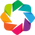

In [31]:
import xarray as xr
import hvplot.xarray
import hvplot.pandas
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import matplotlib as mpl

import geopandas as gpd
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')

hv.extension('bokeh')

In [32]:
RESERVOIR = '0505'
ALG_VERSION = 'v0.1'

RESULTS_DIR = Path(f'../results/')
DATA_DIR = Path(f'../data/')

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
]

res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca'
}
RESERVOIR_NAME = res_names[RESERVOIR]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

global_map = (
    val_res_pt.hvplot(
        geo=True, tiles='OSM'
    ) * val_res_pt[val_res_pt['tmsos_id'] == RESERVOIR].hvplot(
        geo=True, color='red', size=100, 
    )
).opts(
    title=f"Locations of validation reservoirs. {RESERVOIR_NAME}, highlighted in red"
)

global_map

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

In [33]:
(val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].hvplot(
    geo=True, tiles='OSM', shared_axes=False
)).opts(title=f"{RESERVOIR_NAME}")

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [34]:
BUFFER_M = 800 # m

utm_crs = val_polys[val_polys['tmsos_id'] == RESERVOIR].estimate_utm_crs()
print(f"UTM area of use: \n{utm_crs.area_of_use}")

buffered_roi_utm = val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].to_crs(utm_crs).buffer(BUFFER_M).to_crs('epsg:4326')
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')

UTM area of use: 
- name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
- bounds: (90.0, 0.0, 96.0, 84.0)


In [35]:
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"MULTIPOLYGON (((-75.4587 -77.45455, -75.73434 ..."
1,2,Day 01 00:51:30,"MULTIPOLYGON (((84.56768 77.75119, 84.6008 78...."
2,2,Day 01 00:51:30,"MULTIPOLYGON (((-180 -52.37417, -180 -50.92787..."
3,3,Day 01 01:42:50,"MULTIPOLYGON (((-110.19573 -77.57156, -110.161..."
4,4,Day 01 02:34:20,"MULTIPOLYGON (((57.70091 77.75254, 57.69643 78..."
...,...,...,...
845,582,Day 21 18:10:40,"MULTIPOLYGON (((136.37126 77.75111, 136.40526 ..."
846,582,Day 21 18:10:40,"MULTIPOLYGON (((-180 72.80747, -180 73.45033, ..."
847,583,Day 21 19:02:00,"MULTIPOLYGON (((-58.39258 -77.57164, -58.3595 ..."
848,584,Day 21 19:53:30,"MULTIPOLYGON (((109.50449 77.75255, 109.5009 7..."


In [36]:
gd_nadir_fn = Path('/tiger1/pdas47/tmsosPP/data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_nadir = gpd.read_file(gd_nadir_fn)
gd_nadir.head()

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."
2,2,Day 01 00:51:30,"LINESTRING (-180 -52.65544, -179.4133 -53.7198..."
3,3,Day 01 01:42:50,"LINESTRING (-110.20279 -77.66112, -107.53758 -..."
4,4,Day 01 02:34:20,"LINESTRING (57.70176 77.66297, 60.37721 77.650..."


In [37]:
buffered_roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1) # .hvplot(alpha=0.2, lw=2)
buffered_roi_gdf.set_geometry('geometry', inplace=True)

In [38]:
import hvplot.pandas
import geoviews as gv
from holoviews import opts
import matplotlib as mpl
from shapely.geometry import box


gd_track_subset = gd_track[gd_track.intersects(buffered_roi.geometry.values[0])]
gd_nadir_subset = gd_nadir[gd_nadir.ID_PASS.isin(gd_track_subset.ID_PASS)]
gd_nadir_20km = gd_nadir_subset.to_crs(utm_crs).buffer(10000, cap_style='flat').to_crs('epsg:4326')
gd_nadir_20km = gpd.GeoDataFrame(gd_nadir_20km)
gd_nadir_20km = gd_nadir_20km.rename({0: 'geometry'}, axis=1)
gd_nadir_20km.set_geometry('geometry', inplace=True)

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1)
ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1)
view_bounds = box(xlim[0]-1, ylim[0]-1, xlim[1]+1, ylim[1]+1)

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
tracks_hv = gd_track_subset.clip(view_bounds).hvplot(
    geo=True, tiles='OSM', color=gd_track_subset['color'], alpha=0.5, line_width=2,
    xlim=xlim,
    ylim=ylim,
    tools=['hover'], hover_cols=['ID_PASS']
)

nadir_hv = gd_nadir_20km.hvplot(
    geo=True, alpha=0.5, line_width=2, color='lightgreen', line_dash='dashed',
    xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
)

(tracks_hv * nadir_hv * roi_hv).opts(
    title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
)

:Overlay
   .WMTS.I       :WMTS   [Longitude,Latitude]
   .Polygons.I   :Polygons   [Longitude,Latitude]   (_color,ID_PASS)
   .Polygons.II  :Polygons   [Longitude,Latitude]
   .Polygons.III :Polygons   [Longitude,Latitude]

In [39]:
gd_track_subset

,ID_PASS,START_TIME,geometry,color
332,230,Day 09 04:21:20,"MULTIPOLYGON (((12.32584 77.75254, 12.33066 78...",#000004
677,467,Day 17 15:34:10,"MULTIPOLYGON (((3.24679 -77.57162, 3.28003 -77...",#fcffa4


### load data

In [40]:
# load
from pathlib import Path
import pandas as pd

swot_save_dir = Path('/tiger1/pdas47/tmsosPP/data/swot')
swot_save_dir.mkdir(exist_ok=True)

dsses = []
reservoirs = []
available = []
platforms = []
times = []
ds_dict = {reservoir_id: None for reservoir_id in selected_reservoirs}

for reservoir_id in selected_reservoirs:
    fp = swot_save_dir / f'{reservoir_id}.nc'

    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue
    
    ds = xr.open_dataset(fp, chunks='auto', engine='netcdf4', decode_coords='all', )
    dsses.append(ds)
    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(['swot'] * len(ds.time))
    times.extend(ds.time.values)

ds = xr.concat(filter(lambda ds: ds is not None, dsses), dim='time').sortby('time')
ds_dict[reservoir_id] = ds

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})

ds_dict = {f'{tmsos_id}': ds for tmsos_id, ds in zip(selected_reservoirs, dsses)}
df = pd.merge(df, val_res_poly[['tmsos_id', 'geometry']], left_on='reservoir', right_on='tmsos_id', suffixes=(False, False))
df = df.sort_values('time')
df.head()

,reservoir,available,platform,time,tmsos_id,geometry
241,0936,True,swot,2023-04-08,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
242,0936,True,swot,2023-04-09,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
243,0936,True,swot,2023-04-10,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
244,0936,True,swot,2023-04-11,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
245,0936,True,swot,2023-04-12,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."


In [41]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
for i, reservoir_id in enumerate(df.groupby('reservoir').groups):
    data = df.loc[df['reservoir'] == reservoir_id]['time'].reset_index(drop=True)
    name = res_names[reservoir_id]
    ax.eventplot(data, orientation='horizontal', linelengths=0.5, lineoffsets=i)
    yticks.append(i)
    ytick_labels.append(f"{reservoir_id}: {name}")

ax.set_yticks(ticks=yticks, labels=ytick_labels)
ax.set_ylabel('Reservoir ID')
ax.set_xlabel('Time')

ax.set_title('HLS Data downloaded for selected reservoirs')

Text(0.5, 1.0, 'HLS Data downloaded for selected reservoirs')

## plot data for a single reservoir

In [42]:
ds = ds_dict[RESERVOIR]
ds

<xarray.Dataset> Size: 15MB
Dimensions:            (time: 25, y: 162, x: 131)
Coordinates:
  * x                  (x) float64 1kB 3.764e+05 3.765e+05 ... 3.894e+05
  * y                  (y) float64 1kB 2.591e+06 2.591e+06 ... 2.607e+06
    reservoir          <U4 16B ...
    spatial_ref        int64 8B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 200B 2023-07-29 ... 2024-06-14
Data variables:
    water_area         (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    water_frac         (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    wse                (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
    wse_qual           (time, y, x) float32 2MB dask.array<chunksize=(25, 162, 131), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

In [43]:
import holoviews as hv
import hvplot.xarray

ds['wse'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(80, 100) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Surface Elevation (m)'
) + ds['wse_qual'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Surface Elevation Uncertainty (m)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'99d07046-2097-41c2-ae39-c0068f8079f3': {'version…

In [44]:
import holoviews as hv

ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Fraction'
) + ds['water_frac_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Fraction Uncertainty'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8c3c33c8-fb96-4e3a-98be-53761c6b606d': {'version…

In [45]:
import holoviews as hv

ds['water_area'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area'
) + ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3d104ce8-c4a3-4242-bfee-9d76b27a5d94': {'version…

# Temporal resampling to 21-days

Due to partial coverage by the SWOT satellite's KaRIN sensor's swath, there may be incomplete information for estimating area. One way to handle this is to use resample the dataset temporally to that of the repeat period of the satellite. This way, even if a reservoir is partially observed in a single pass, other passes within the next 21 days may cover the entire reservoir.

We will resample the data to a 21 day interval to match the repeat period of the SWOT satellite.

In [46]:
import dask.array 

rs_area_qual = ds['water_area_qual']

def _swot_quality_bits_resampler(a, rs_area_qual, **axis):
    rs_area_qual_idx = rs_area_qual.isel(time=xr.DataArray(a).dim_0.values).reduce(
        np.argmin, dim='time'
    ) # array containing the index along a.shape[0] from which to pick the value of the 
      # resulting array

    return rs_area_qual_idx

def swot_area_resampler(a, rs_area_qual, **axis):
    rs_area_qual_idx = _swot_quality_bits_resampler(a, rs_area_qual, **axis)
    rs_area_composite = np.choose(rs_area_qual_idx.data, a)
    return rs_area_composite

def swot_area_qual_bits_resampler(a, rs_area_qual, **axis):
    print(xr.DataArray(a).values.shape, '\n\n')
    rs_area_qual_idx = _swot_quality_bits_resampler(a, rs_area_qual, **axis)
    return rs_area_qual_idx

def resample_swot(swot_ds):
    ds = swot_ds
    resampled_qual_bits_idx = ds[['water_frac', 'water_area_qual', 'wse']].resample(time='21D')
    resampled_area_template = ds[['water_frac']].resample(time='21D').reduce(np.nanmean)
    resampled_area_qual_template = ds[['water_area_qual']].resample(time='21D').reduce(np.nanmean)
    resampled_wse_qual_template = ds[['wse_qual']].resample(time='21D').reduce(np.nanmean)

    for gp, subset in resampled_qual_bits_idx:
        NODATA = 1e3
        rs_area_qual_idx = subset['water_area_qual'].fillna(NODATA).reduce(np.nanargmin, dim='time')
        rs_area_qual_idx = rs_area_qual_idx.where(rs_area_qual_idx != NODATA, 0)
        rs_area_composite = xr.DataArray(np.choose(rs_area_qual_idx.values, subset['water_frac'].values))
        rs_area_composite = rs_area_composite.rename('water_frac')
        rs_area_composite = rs_area_composite.rename({'dim_0': 'y', 'dim_1': 'x'})
        rs_area_composite = rs_area_composite.clip(0, 1)

        resampled_area_qual_template.loc[dict(time=gp)] = rs_area_qual_idx
        resampled_area_template.loc[dict(time=gp)] = rs_area_composite
    
    resampled_wse = ds[['wse']].resample(time='21D').reduce(np.nanmean)

    resampled = xr.merge([
        resampled_area_template, resampled_wse, 
        resampled_area_qual_template, resampled_wse_qual_template])

    return resampled

resampled = resample_swot(ds)
resampled

<xarray.Dataset> Size: 5MB
Dimensions:          (x: 131, y: 162, time: 16)
Coordinates:
  * x                (x) float64 1kB 3.764e+05 3.765e+05 ... 3.893e+05 3.894e+05
  * y                (y) float64 1kB 2.591e+06 2.591e+06 ... 2.607e+06 2.607e+06
  * time             (time) datetime64[ns] 128B 2023-07-29 ... 2024-06-08
    reservoir        <U4 16B '0505'
    spatial_ref      int64 8B 0
    crs              int64 8B 0
Data variables:
    water_frac       (time, y, x) float32 1MB dask.array<chunksize=(1, 162, 131), meta=np.ndarray>
    wse              (time, y, x) float32 1MB dask.array<chunksize=(1, 162, 131), meta=np.ndarray>
    water_area_qual  (time, y, x) float32 1MB dask.array<chunksize=(1, 162, 131), meta=np.ndarray>
    wse_qual         (time, y, x) float32 1MB dask.array<chunksize=(1, 162, 131), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

Plot water surface area.

In [47]:
(resampled['water_frac'].sum(dim=('x', 'y'))*1e-6*1e4).hvplot(kind='scatter').opts(
    ylabel='Water Area (km2)', xlabel='Date', title=f'{RESERVOIR_NAME} area time series (resampled to 21 days)'
)

:Scatter   [time]   (water_frac)

Plot water surface elevation.

In [48]:
resampled['wse'].mean(dim=['x', 'y']).hvplot(
    label='WSE', kind='scatter'
).opts(
    ylabel='Water Surface Elevation', title='Water Surface Elevation (WSE) [m]'
)

:Scatter   [time]   (wse)

Plot area and elevation maps.

In [49]:
resampled['water_frac'].hvplot(
    x='x', y='y'
).opts(aspect='equal', width=400) + resampled['wse'].hvplot(
    x='x', y='y', clim=(120, 160)
).opts(aspect='equal', width=400)

BokehModel(combine_events=True, render_bundle={'docs_json': {'27737c2d-3e9d-490b-86f5-dd9e17afdc36': {'version…

Plot dummy classified water map based on threshold of water fraction.

In [50]:
THRESHOLD = 0.5

(resampled['water_frac'].where(resampled['water_frac'] > THRESHOLD)).hvplot(
    x='x', y='y', groupby='time'
).opts(title=f'Water Fraction raster. {RESERVOIR_NAME}.', aspect='equal', width=400) \
+ (resampled['wse'].where(resampled['water_frac'] > THRESHOLD)).hvplot(
    x='x', y='y', groupby='time', clim=(120, 160)
).opts(title=f'Water Surface Elevation raster. {RESERVOIR_NAME}.', aspect='equal', width=400)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4f9af008-d66e-4cbe-bd6c-b87c9087ccd0': {'version…

Plot the Area-Elevation curve.

In [51]:
area_ts = resampled['water_frac'].sum(dim=('x', 'y')) * 1e-6 * 1e4
wse_ts = resampled['wse'].where(resampled['water_frac'] > 0.5).mean(dim=('x', 'y'))

aec = xr.Dataset(data_vars = {
    'area': (['reservoir', 'time'], [area_ts]), 
    'elevation': (['reservoir', 'time'], [wse_ts])
}, 
coords={'reservoir': [RESERVOIR], 'time': area_ts.time.values})

aec_hv = aec.sel(reservoir=RESERVOIR).hvplot(
    x='area', y='elevation', kind='scatter', by='time', color='black'
).opts(aspect='equal', width=400, height=400, ylabel='Elevation (m)', xlabel='Area (km2)', show_legend=False, title=f'SWOT derived AEC, {RESERVOIR_NAME}')
aec_hv

:NdOverlay   [time]
   :Scatter   [area]   (elevation)

save figure.

In [52]:
import holoviews as hv
hv.extension('matplotlib')
fig_save_fp = RESULTS_DIR / 'figures' / f'{ALG_VERSION}' / f'{RESERVOIR}_tmsswot{ALG_VERSION}.png'
fig_save_fp.parent.mkdir(exist_ok=True, parents=True)
hv.save(aec_hv.opts(title=f'Area-Elevation Curve for {RESERVOIR_NAME}', show_legend=False, width=300, height=300), fig_save_fp, fmt='png')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

## Classify water for single reservoir

In [53]:
import rioxarray

ds = ds.rio.set_spatial_dims('y', 'x')
ds = ds.rio.write_crs(utm_crs)
ds = ds.rio.clip(buffered_roi.to_crs(ds.rio.crs).geometry.values)
ds

<xarray.Dataset> Size: 10MB
Dimensions:            (x: 107, y: 138, time: 25)
Coordinates:
  * x                  (x) float64 856B 3.776e+05 3.777e+05 ... 3.882e+05
  * y                  (y) float64 1kB 2.592e+06 2.592e+06 ... 2.606e+06
    reservoir          <U4 16B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 200B 2023-07-29 ... 2024-06-14
    spatial_ref        int64 8B 0
Data variables:
    water_area         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_frac         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse                (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse_qual           (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
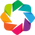

ROI CRS:  epsg:4326
roi (epsg:4326) total bounds:  [91.80090404 23.43194804 91.90540145 23.55597079]
tile limits:  80 20 90 30
tiles:  ['80E_20N', '80E_30N', '90E_20N', '90E_30N']


<xarray.DataArray 'occurrence' (y: 138, x: 107)> Size: 118kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 856B 3.776e+05 3.777e+05 ... 3.881e+05 3.882e+05
  * y            (y) float64 1kB 2.592e+06 2.592e+06 ... 2.605e+06 2.606e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [54]:
from rasterio.crs import CRS
import rioxarray
import dask
import numpy as np
from tmsswot.data import get_occurrence_like

hv.extension('bokeh')

pekel_dir = Path('../data/pekel/occurrence_nc')
occurrence = get_occurrence_like(buffered_roi, reproject_match=ds['water_frac'], pekel_dir=pekel_dir, stretching_factor=1)
occurrence

In [55]:
occurrence.hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 100), geo=True, # crs=ds.rio.crs
).opts(
    title='Occurrence (%)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'407d8553-277c-444f-9b6c-d1190131cc8a': {'version…

In [56]:
# xr.open_dataset('../data/pekel/occurrence_nc/occurrence_90E_10Nv1_4_2021.nc').fillna(0).astype(int).sel(band=1).hvplot(
#     x='x', y='y'
# ).opts(aspect='equal')

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from tmsswot.classify import get_swot_missing_data

def classify_swot(
        swot_ds, 
        roi, 
        occurrence, 
        water_frac_threshold=0.7, 
        area_qual_threshold=2, 
        wse_qual_threshold=1, 
        zg_omega=0.3
    ):
    swot_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    swot_ds.rio.write_crs(CRS.from_wkt(swot_ds.spatial_ref.attrs['crs_wkt']), inplace=True)

    # resample to 21 days
    swot_ds = resample_swot(swot_ds)

    water_map = (swot_ds['water_frac'].where(swot_ds['water_area_qual'] <= area_qual_threshold) > water_frac_threshold) * 1
    water_map = water_map > water_frac_threshold
    water_map = xr.where(~np.isnan(swot_ds['water_frac']).data, water_map, np.nan)
    water_map = water_map.rio.set_crs(swot_ds.rio.crs)
    water_map.attrs['standard_name'] = "surface_water"
    water_map.attrs['long_name'] = "Surface water of lake/reservoir observed by SWOT"
    water_map = water_map.rename('surface_water')

    missing_mask = xr.DataArray(data=np.isnan(water_map), dims=water_map.dims, coords=water_map.coords, name='missing_mask')
    swot_missing_data = get_swot_missing_data(swot_ds, roi, area_qual_threshold, wse_qual_threshold)
    missing_mask['missing_mask'] = swot_missing_data['missing_mask'] | missing_mask
        
    # enhance using historical occurrence data
    water_map = water_map.chunk({'time': 50, 'x': -1, 'y': -1})
    water_map = water_map.transpose('time', 'y', 'x')
    water_map_uncorrected = water_map.copy()
    missing_fraction = missing_mask['missing_mask'].sum(dim=('x', 'y')).values / missing_mask['missing_mask'].size
    missing_fraction = xr.DataArray(
        data=(missing_fraction - missing_fraction.min())/(missing_fraction.max() - missing_fraction.min()), 
        dims=['time'], coords={'time': water_map.time}, name='missing_fraction')
    missing_fraction = missing_fraction.rename('missing_fraction')
    missing_fraction.attrs['standard_name'] = "missing_fraction"
    missing_fraction.attrs['long_name'] = "Fraction of data missing over the lake/reservoir observed by SWOT"
    missing_fraction.attrs['unit'] = "1"

    def zg(water_map_block):
            times = water_map_block.time
            res = xr.zeros_like(water_map_block)

            for i, time in enumerate(times):
                water_map_slice = water_map_block.sel(time=time)
                if missing_fraction.sel(time=time) <= 0.95:
                    mask_slice = missing_mask.sel(time=time)
                    
                    occurrence_slice = xr.where(~mask_slice, occurrence, np.nan)
                    occurrence_slice = xr.where(water_map_slice==1, occurrence_slice, 0)
                    occurrence_counts, occurrence_values = np.histogram(occurrence_slice.values, bins=99, range=(1, 100))
                    count_threshold = np.nanmean(occurrence_counts) * zg_omega
                    occurrence_idx = np.nanargmax(np.where(occurrence_counts > count_threshold) if (occurrence_counts > count_threshold).sum() > 0 else [0])
                    occurrence_idx = np.nan if occurrence_idx == 0 else occurrence_idx
                    
                    pekel_estimated_map = (occurrence >= occurrence_idx)
            
                    corrected_map = xr.where(
                        missing_mask['missing_mask'].sel(time=time) == 1, 
                        pekel_estimated_map,
                        water_map_slice
                    )
                    res.data[i] = corrected_map
                else:
                    res.data[i] = np.full_like(water_map_slice, 2)
            
            return res
    water_map = water_map.map_blocks(
        zg, template=water_map
    ).rename("surface_water")
    water_map.rio.set_nodata(2, inplace=True)
        
    # water_map = water_map.where(valid_data)
    # water_map = xr.where(valid_data, water_map, np.nan)

    water_map_area = xr.where(water_map!=1, np.nan, swot_ds['water_frac']).sum(dim=('x', 'y')) * 1e-6 * 1e4 # km^2
    water_map_area.attrs['standard_name'] = "surface_water_area"
    water_map_area.attrs['long_name'] = "Surface water area of lake/reservoir observed by SWOT"
    water_map_area.attrs['unit'] = "km^2"
    water_map_area = water_map_area.rename('surface_water_area')

    water_surface_elevation_raster = xr.where(missing_mask['missing_mask'], np.nan, swot_ds['wse'])
    water_surface_elevation_raster = water_surface_elevation_raster.where(swot_ds['wse_qual'] <= wse_qual_threshold)
    water_surface_elevation_raster = xr.where(water_map == 1, water_surface_elevation_raster, np.nan).rename('surface_water_elevation_raster')
    water_surface_elevation_raster.attrs['standard_name'] = "surface_water_elevation_raster"
    water_surface_elevation_raster.attrs['long_name'] = "Surface water elevation of lake/reservoir observed by SWOT"
    water_surface_elevation_raster.attrs['unit'] = "m"

    water_missing_fraction = missing_fraction
    water_missing_fraction.attrs['standard_name'] = "missing_fraction"
    water_missing_fraction.attrs['long_name'] = "Fraction of data missing over the lake/reservoir observed by SWOT"
    water_missing_fraction.attrs['unit'] = "1"
    water_missing_fraction = water_missing_fraction.rename('missing_fraction')

    water_surface_elevation = water_surface_elevation_raster.mean(dim=['x', 'y'])
    water_surface_elevation.attrs['standard_name'] = "surface_water_elevation"
    water_surface_elevation.attrs['long_name'] = "Water Surface Elevation observed by SWOT"
    water_surface_elevation.attrs['unit'] = "m"
    water_surface_elevation = water_surface_elevation.rename('surface_water_elevation')

    storage_change = (water_map_area[1:] - water_map_area[:-1]) * (water_surface_elevation[1:] + water_surface_elevation[:-1]) * 0.5 * 1e6
    storage_change.attrs['standard_name'] = "storage_change"
    storage_change.attrs['long_name'] = "Change in storage of lake/reservoir observed by SWOT"
    storage_change.attrs['unit'] = "m^3"
    storage_change = storage_change.rename('storage_change')

    time_since_last_obs = (water_map_area.time[1:] - water_map_area.time[:-1]).astype('timedelta64[D]')
    time_since_last_obs.attrs['standard_name'] = "time_since_last_obs"
    time_since_last_obs.attrs['long_name'] = "Time since last observation of lake/reservoir observed by SWOT"
    time_since_last_obs.attrs['unit'] = "days"
    time_since_last_obs = time_since_last_obs.rename('time_since_last_obs')

    swot_ds = xr.merge([
        water_map, water_map_area, water_surface_elevation_raster, 
        water_surface_elevation, water_missing_fraction, storage_change, time_since_last_obs
    ])

    swot_ds['surface_water_area'] = xr.where(missing_fraction > 0.9, np.nan, swot_ds['surface_water_area'])
    swot_ds['surface_water_elevation'] = xr.where(missing_fraction > 0.9, np.nan, swot_ds['surface_water_elevation'])

    # calculate z score for surface_water_area
    swot_ds['surface_water_area_z'] = (swot_ds['surface_water_area'] - swot_ds['surface_water_area'].mean()) / swot_ds['surface_water_area'].std()

    return swot_ds

In [59]:
# from tmsswot.classify import classify_swot

swot_ds = classify_swot(
    ds, buffered_roi, occurrence, 
    water_frac_threshold=0.25, area_qual_threshold=2, wse_qual_threshold=2
)
swot_ds

<xarray.Dataset> Size: 5MB
Dimensions:                         (x: 107, y: 138, time: 16)
Coordinates:
  * x                               (x) float64 856B 3.776e+05 ... 3.882e+05
  * y                               (y) float64 1kB 2.592e+06 ... 2.606e+06
  * time                            (time) datetime64[ns] 128B 2023-07-29 ......
    reservoir                       <U4 16B '0505'
    crs                             int64 8B 0
    spatial_ref                     int64 8B 0
    missing_mask                    (time, y, x) int64 2MB dask.array<chunksize=(1, 138, 107), meta=np.ndarray>
Data variables:
    surface_water                   (time, y, x) float64 2MB dask.array<chunksize=(16, 138, 107), meta=np.ndarray>
    surface_water_area              (time) float32 64B dask.array<chunksize=(1,), meta=np.ndarray>
    surface_water_elevation_raster  (time, y, x) float32 945kB dask.array<chunksize=(1, 138, 107), meta=np.ndarray>
    surface_water_elevation         (time) float32 64B dask.array<chunksize=(1,), meta=np.ndarray>
    missing_fraction                (time) float64 128B 0.1381 0.0 ... 0.03883
    storage_change                  (time) float32 64B dask.array<chunksize=(2,), meta=np.ndarray>
    time_since_last_obs             (time) timedelta64[ns] 128B NaT ... NaT
    surface_water_area_z            (time) float32 64B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    standard_name:  surface_water
    long_name:      Surface water of lake/reservoir observed by SWOT

In [60]:
ds

<xarray.Dataset> Size: 10MB
Dimensions:            (x: 107, y: 138, time: 25)
Coordinates:
  * x                  (x) float64 856B 3.776e+05 3.777e+05 ... 3.882e+05
  * y                  (y) float64 1kB 2.592e+06 2.592e+06 ... 2.606e+06
    reservoir          <U4 16B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 200B 2023-07-29 ... 2024-06-14
    spatial_ref        int64 8B 0
Data variables:
    water_area         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_frac         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse                (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
    wse_qual           (time, y, x) float32 1MB dask.array<chunksize=(25, 138, 107), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

In [61]:
swot_ds ['surface_water_elevation'].hvplot(kind='scatter')

:Scatter   [time]   (surface_water_elevation)

In [62]:
swot_ds['surface_water_area_z'].hvplot().opts(title='Z score of surface water area') * hv.HLine(0).opts(line_dash='dashed', color='gray')

:Overlay
   .Curve.I :Curve   [time]   (surface_water_area_z)
   .HLine.I :HLine   [x,y]

In [63]:
swot_ds['surface_water'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Surface Water'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'6e7ef1eb-470c-4455-9532-97ecdf48aff9': {'version…

In [64]:
gd_nadir_20km.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
# swot_ds.rio.clip(gd_nadir_20km.to_crs(swot_ds.rio.crs).geometry.values, invert=True)

In [66]:
((
    swot_ds['surface_water']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1), # crs=swot_ds.rio.crs
).opts(
    title='Surface water'
) + (
    swot_ds['surface_water_elevation_raster']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal'
).opts(
    title='Water Elevation'
) + (
    swot_ds['surface_water_area']).hvplot(
        label='Area', kind='scatter'
).opts(
    width=400, title='Area'
) + (
swot_ds['surface_water_elevation']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Water Surface Elevation'
) + (
swot_ds['missing_fraction']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Missing data rate'
) * hv.HLine(0.9).opts(line_dash='dashed', color='gray')).cols(2)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d5949ec2-48d3-4549-bde1-70d4228485f4': {'version…

In [67]:
swot_hv = swot_ds.mean(dim=('x', 'y')).hvplot(
    x='surface_water_area', y='surface_water_elevation', kind='scatter', by='time', 
    c='missing_fraction', cmap='kr', clabel='Fraction of missing data over reservoir',
).opts(
    xlabel='Water Area (km2)', ylabel='Surface Water Elevation (m)',
    title=f'Area-Elevation curve for {RESERVOIR_NAME}'
)

fig_save_fp = RESULTS_DIR / 'figures' / f'{ALG_VERSION}' / 'AEC' / f'{RESERVOIR}_tmsswot{ALG_VERSION}.png'
fig_save_fp.parent.mkdir(exist_ok=True)
hv.save(swot_hv.opts(show_legend=False), fig_save_fp, fmt='png')

In [68]:
swot_hv

:NdOverlay   [time]
   :Scatter   [surface_water_area]   (surface_water_elevation,missing_fraction)

In [69]:
swot_ds['storage_change'].hvplot( # not working
    x='time', label='∆S'
)

:Curve   [time]   (storage_change)

save data.

In [39]:
# save_fp = DATA_DIR / 'swot' / f'{RESERVOIR}_swot_{ALG_VERSION}.nc'
# swot_ds.to_netcdf(save_fp)

## time-series plot

##### end of notebook